# Introduction

## William Koehrsen wjk68

In this notebook we will verify the implementation of Independent Component Analysis (ICA) that was implemented in the first problem. We will perform ICA using our method on a set of independent samples that are linearly combined into a signal using a known mixing matrix. The algorithm will return both the sources and the mixing matrix which can be compared to the ground-truth. The original signal can also be reconstructed from the sources and mixing matrix (and the mean that was subtracted to center the features). 

We will also compare the results to the [FastICA implementation in Scikit-learn](http://scikit-learn.org/stable/modules/decomposition.html#ica). 

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Generating signals
from scipy import signal

# Echelon form of matrix for checking independence
import sympy

# Validation with established ICA implementation
from sklearn.decomposition import FastICA

### Import Algorithm

In [2]:
from parallel_ica import perform_fastica, inverse_fastica

# Generate Independent Samples

We will use three independent samples that are combined linearly using a mixing matrix into one signal. As we know both the original samples and the mixing matrix, we can compare the results with the ground truth to verify the implementation.

In [3]:
# X values
time = np.linspace(0, 20, 1000)

# Signals
s1 = 1.4 * np.cos(time)
s2 = signal.sawtooth(time - 1.2)
s3 = 0.75 * signal.square(time)

### Visualize Signals

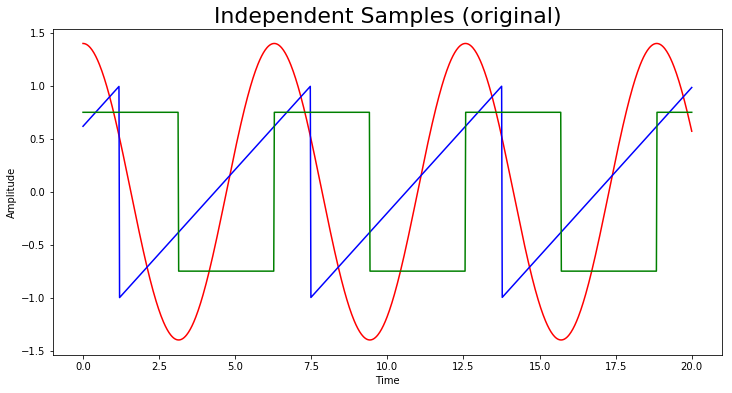

In [4]:
plt.figure(figsize=(12, 6))
colors = ['red', 'blue', 'green']

# Plot original samples
for i, s in enumerate([s1, s2, s3]):
    plt.plot(time, s, color = colors[i])

plt.title('Independent Samples (original)', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

#### Distribution of Samples

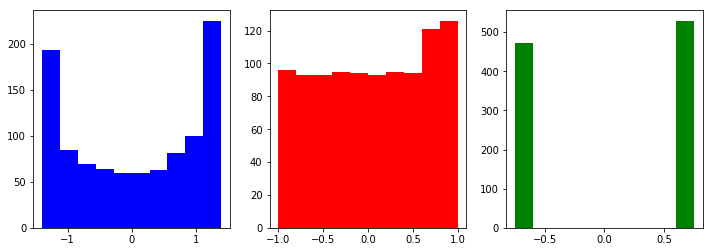

In [5]:
plt.figure(figsize=(12, 4));
plt.subplot(131);
plt.hist(s1, color = 'blue');
plt.subplot(132);
plt.hist(s2, color = 'red');
plt.subplot(133);
plt.hist(s3, color = 'green');

The amplitude of the samples are not Gaussian as shown by the distribution. Independent Component Analysis assumes that the signal is a linear combination of non-Gaussian samples, which means that it should work to separate these samples when they are combined. 

### Add Noise

We will add a small amount of random noise to each signal. 

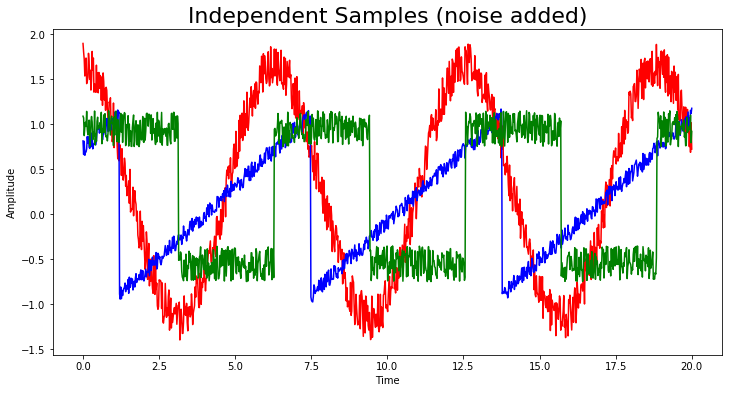

In [6]:
plt.figure(figsize=(12, 6))
s1 += 0.5 * np.random.rand(s1.shape[0])
s2 += 0.2 * np.random.rand(s2.shape[0])
s3 += 0.4 * np.random.rand(s3.shape[0])

for i, s in enumerate([s1, s2, s3]):
    plt.plot(time, s, color = colors[i])

plt.title('Independent Samples (noise added)', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

# Combine Samples Into Signal Using Mixing Matrix

Now we will take the individual samples and combine them into a single signal. First, we concantenate the individual vectors to get a matrix of shape [n_samples, n_features]. Then, we use a defined mixing matrix of shape [n_samples, n_samples] to linearly combine the samples into a single signal. The equation for the signal is 

$$X = AS$$ 
where X, the signal, is the matrix product of A, the mixing matrix, and S, the individual sample matrix.

In [7]:
# Combine the samples
S = np.array([s1, s2, s3])

# Standard the samples
S = np.divide(S.T, S.std(axis=1)).T

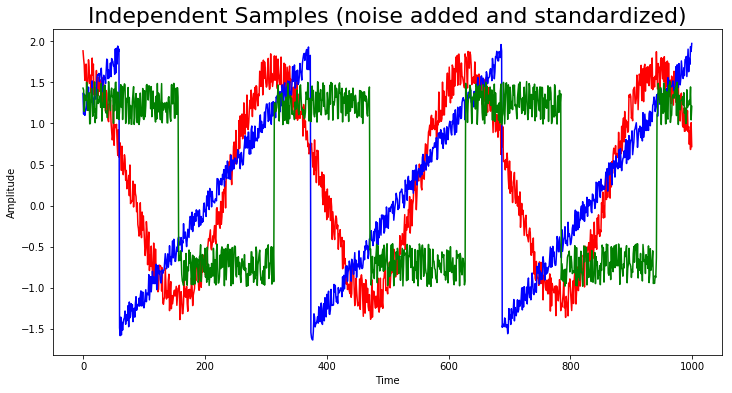

In [8]:
plt.figure(figsize=(12, 6))
for i in range(S.shape[0]):
    plt.plot(S[i, :], color = colors[i])
    
plt.title('Independent Samples (noise added and standardized)', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

## Check for Indepedence 

To check if the samples are truly independent, we can convert the matrix to [echelon form and see if any of the rows are 0](http://faculty.bard.edu/belk/math213f12/LinearDependence.pdf). The operation checks for linear depedence between rows. As each row is a separate sample, this checks to see if the samples are lienarly dependent. We use the `sympy` library for this. 

In [9]:
# Create a sympy matrix
M = sympy.Matrix(S)

# Convert to echelon form
echelon_s = np.array(M.rref()[0])

# Check if any rows are all 0
(echelon_s == 0).all(axis=1)

array([False, False, False])

To check whether any of the rows contain all zeros, I consulted [this Stack Overflow question](https://stackoverflow.com/questions/23726026/finding-which-rows-have-all-elements-as-zeros-in-a-matrix-with-numpy). From these results, we can conclude that the samples are independent. Now, we will mix them together into one signal using a mixing matrix we define.

## Mix Samples

In [10]:
# Mixing matrix
A = np.array([[2.4, 0.9, 3],
             [1, 1, 1],
             [2.3, 1.2, 2.4]])

# Mix samples
X = np.dot(A, S)

## Visualize Signal

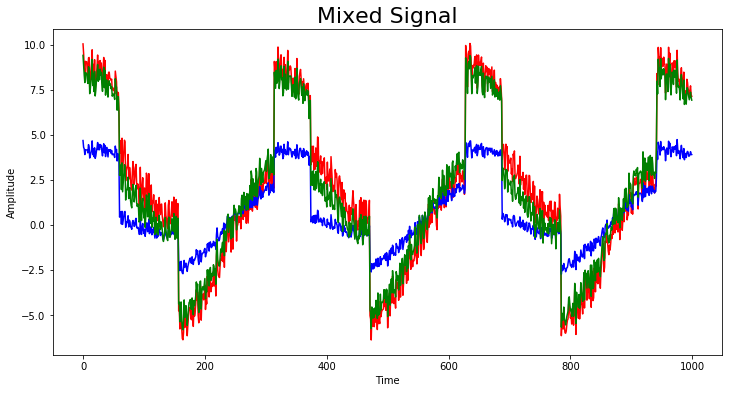

In [11]:
plt.figure(figsize=(12, 6))
for i in range(X.shape[0]):
    plt.plot(X[i, :], color = colors[i])
    
plt.title('Mixed Signal', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

# Apply Independent Component Analysis

We can now implement our algorithm to find the mixing matrix and sources. To check the results, we can compare the mixing matrix with the known value and also visualize the sources.

In [12]:
# Transformation
mixing, sources, X_mean = perform_fastica(X.T, n_components=3)

## Check to See if Inverse Transform is Correct

As a check, we can make sure we are able to reconstruct the original signal from the mixing matrix and source (and mean because it was subtracted to center the signal). 

In [13]:
np.allclose(np.dot(sources, mixing.T), X.T)

True

This proves that our algorithm was able to decompose and re-construct the original signal. At least that much of the implementation is correct, but the question is whether the implementation was able to separate out independent components?

## Compare Mixing Matrix with Ground Truth

In [14]:
print(A)
print(mixing.T)

[[2.4 0.9 3. ]
 [1.  1.  1. ]
 [2.3 1.2 2.4]]
[[  94.7529744    30.0664043    75.0257739 ]
 [ -99.0288074   -54.90278739 -101.90340295]
 [ -14.2913011   -20.67101302  -22.67741526]]


Those values are not even close! We can compare the scikit-learn results for the mixing matrix to see if we should get the original mixing matrix we used. 

## Visualize Identified Sources

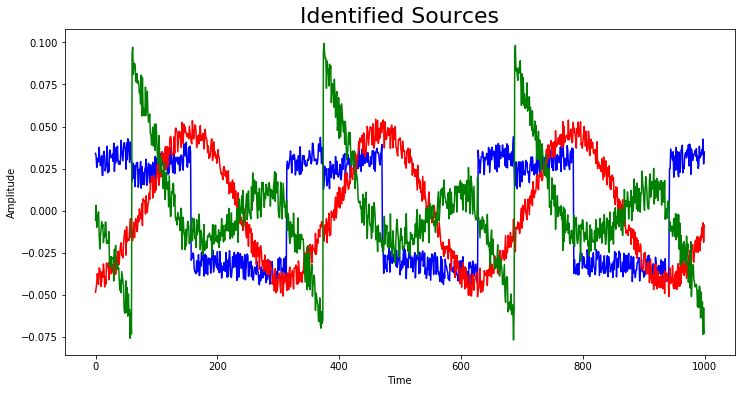

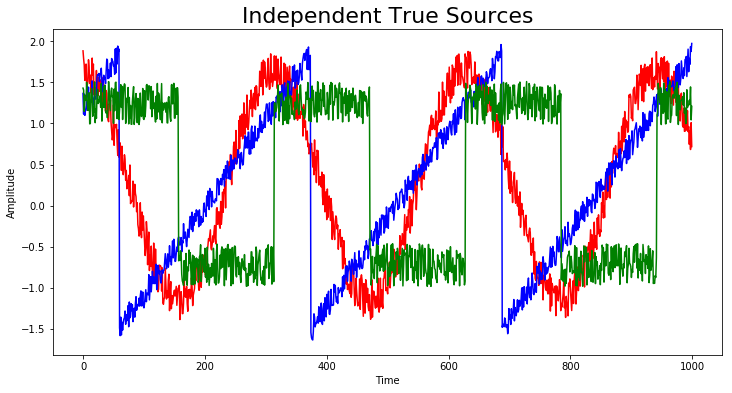

In [15]:
colors_s = ['blue', 'red', 'green']
plt.figure(figsize=(12, 6))
for i in range(sources.T.shape[0]):
    plt.plot(sources.T[i, :], color = colors_s[i])
    
plt.title('Identified Sources', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

plt.figure(figsize=(12, 6))
for i in range(S.shape[0]):
    plt.plot(S[i, :], color = colors[i])
    
plt.title('Independent True Sources', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

The implementation of FastICA did pretty well. The method was able to identify the independent samples within a sign change and constant. Given that we already saw we can reconstruct the original signal from the mixing matrix and sources, we can conclude that this implementation of Independent Component Analysis is correct. The last step is to compare the results with those from scikit-learn, a popular machine learning and processing library.

# Compare to Scikit-learn Implementation

In [16]:
# Create ICA and transform into the sources
ica = FastICA(n_components=3)
sk_sources = ica.fit_transform(X.T)

# Check if the method can reconstruct the signal
np.allclose(ica.inverse_transform(sk_sources), X.T)

True

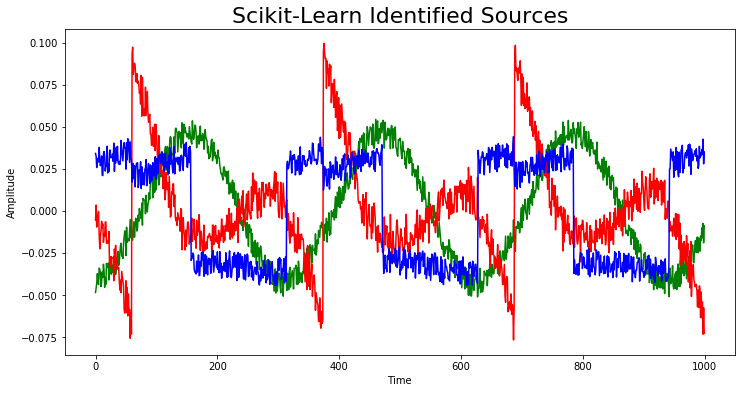

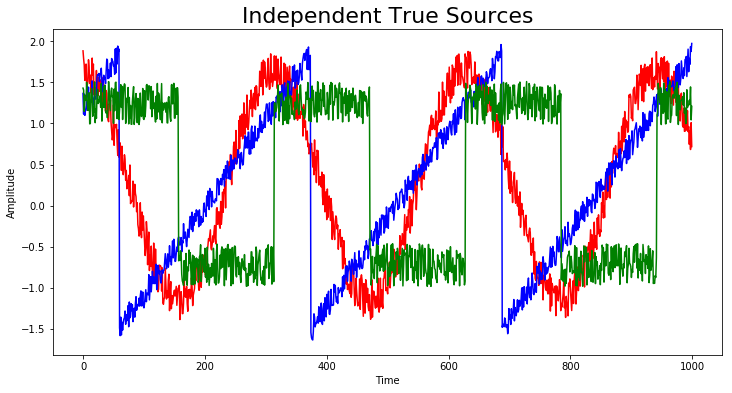

In [17]:
colors_s = ['green', 'red', 'blue']

plt.figure(figsize=(12, 6))
for i in range(sk_sources.T.shape[0]):
    plt.plot(sk_sources.T[i, :], color = colors_s[i])
    
plt.title('Scikit-Learn Identified Sources', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

plt.figure(figsize=(12, 6))
for i in range(S.shape[0]):
    plt.plot(S[i, :], color = colors[i])
    
plt.title('Independent True Sources', size = 22)
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show(); 

The scikit-learn implementation was also able to identify the independent samples. In both cases, the identified sources and the true sources have the same form but differ in sign and a multiplicative constant. We can also check the mixing matrix from this implementation.

In [18]:
print(A)
print(ica.mixing_.T)

[[2.4 0.9 3. ]
 [1.  1.  1. ]
 [2.3 1.2 2.4]]
[[ -99.00578455  -54.96860702 -101.93658593]
 [ -13.68655005  -20.37212286  -22.09157588]
 [  94.86624855   30.15003088   75.15537353]]


Again, we see that the mixing matrix looks nothing like the original. I am not sure what the reason for this could be and doing some research ([1](http://www.cs.jhu.edu/~ayuille/courses/Stat161-261-Spring14/HyvO00-icatut.pdf), [2](https://stackoverflow.com/questions/37964170/what-does-the-scikit-fastica-return-and-what-is-the-difference-between-fastica-a) I was not able to determine the answer. I know that FastICA is not a deterministic algorithm, so I expect different mixing matrices on every run, but I would think they would be close to the original or within a constant of the original. However, this does not seem to be the case and I would like to find out more to explain this result.

# Conclusions

In this notebook we validation the implementation of FastICA using known independent samples and a defined mixing matrix. We saw that our algorithm was able to separate out the independent sources that were within a sign change and a constant of the original samples. Moreover, using the mixing matrix and the identified sources, we could correctly re-construct the signal. However, the mixing matrix returned by the method was not close to that we defined to combine the samples. I was not able to determine why this is the case. FastICA is not a deterministic algorithm and will return different mixing matrices and sources on each run, but the mixing matrix was not close the original at all. This requires more research on my part. 

Furthermore, we tested the scikit-learn implementation of FastICA and found similar results. The method did not correctly identify the mixing matrix, but did separate out the correct samples. Overall, this notebook validated our implementation of FastICA and raised a question about the mixing matrix interpretation that will require some follow-up. We have confidence (at least for a problem we define) that our version of FastICA can separate out non-Guassian independent components from a signal. 